In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)


In [4]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# clean data
dataset = dataset.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [7]:
# Split the data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [8]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG') 

In [9]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(10,8))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if x is not None and y is not None:
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

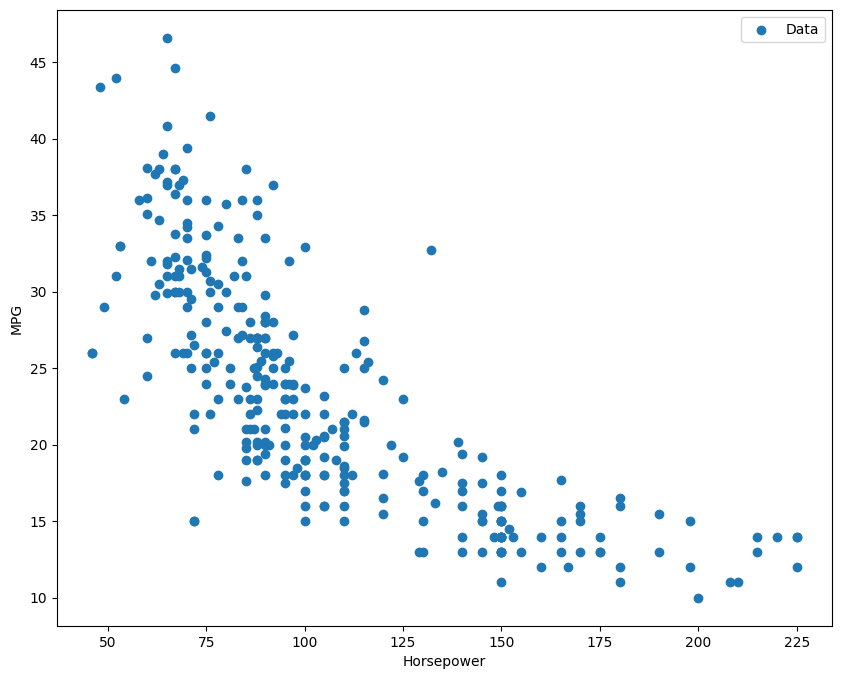

In [10]:
plot('Horsepower')

In [11]:
# Normalize
#print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
#print(normalizer.mean.numpy())

print(train_features)

     Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
146          4          90.0        75.0  2125.0          14.5          74   
282          4         140.0        88.0  2890.0          17.3          79   
69           8         350.0       160.0  4456.0          13.5          72   
378          4         105.0        63.0  2125.0          14.7          82   
331          4          97.0        67.0  2145.0          18.0          80   
..         ...           ...         ...     ...           ...         ...   
281          6         200.0        85.0  2990.0          18.2          79   
229          8         400.0       180.0  4220.0          11.1          77   
150          4         108.0        93.0  2391.0          15.5          74   
145          4          83.0        61.0  2003.0          19.0          74   
182          4         107.0        86.0  2464.0          15.5          76   

     USA  Europe  Japan  
146    1       0      0  
282    1   

In [12]:
# When the layer is called it returns the input data, with each feature independently normalized:
# (input-mean)/stddev
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [13]:
# Regression
# 1. Normalize the input horsepower
# 2. Apply a linear transformation (y = m*x+b) to produce 1 output using layers.Dense

feature = 'Horsepower'
single_feature = np.array(train_features[feature], 0)
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = preprocessing.Normalization()

#print(single_feature)
# adapt to the data
single_feature_normalizer.adapt(train_features[feature])

TypeError: Cannot interpret '0' as a data type

In [21]:
a = np.array([1., 2., 3.], dtype='float32')
b = np.array([[1.], [2.], [3.]], dtype='float32')

d = np.reshape(a,(1, a.size))

print(a.shape, b.shape, d.shape)
print(d)

(3,) (3, 1) (1, 3)
[[1. 2. 3.]]


In [15]:
c = preprocessing.Normalization()

c.adapt(b)

print(c)